## In this notebook I'll provide an example of a fit using the customized emission template. This framework let's you flexibly tie Gaussian model parameters for a series of custom Gaussian emission lines

In [2]:
import math
import numpy as np
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15,8
import os
import glob
from lmfit import Parameters, fit_report, minimize
import time
import corner

from SpecDecomp import SpecDecomp

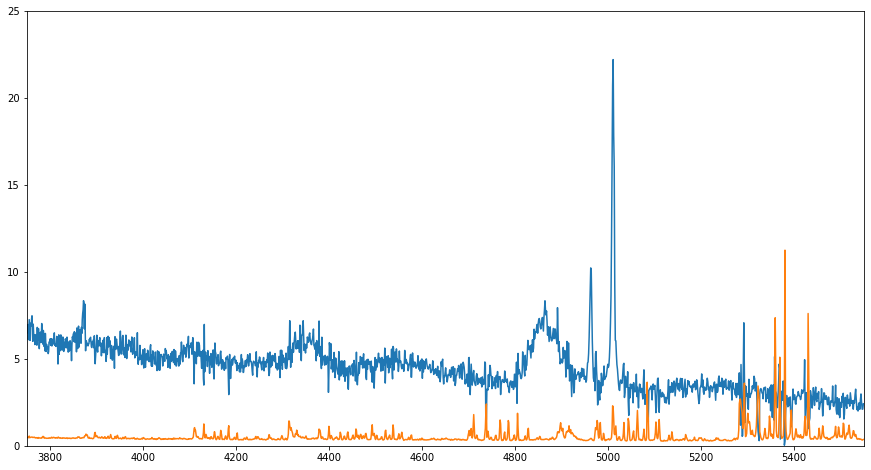

In [3]:
# load in example spectrum

data=np.load('./files/spec-9141-57663-0789_unred_z.npy',allow_pickle=True)
WL=data.item().get('WL')
INT=data.item().get('INT')
ERR=data.item().get('ERR')

# Initialize Spectral Decomposition Class
spec=SpecDecomp(WL,INT,ERR)

# clip data onto desired wavelength
minWL=3750       # minimum wavelength for fitting
maxWL=5550       # maximum wavelength for fitting
spec.clip_data_wavelength(minWL,maxWL)

plt.axis([minWL,maxWL,0,25])
plt.plot(spec.wave,spec.flux)
plt.plot(spec.wave,spec.err)


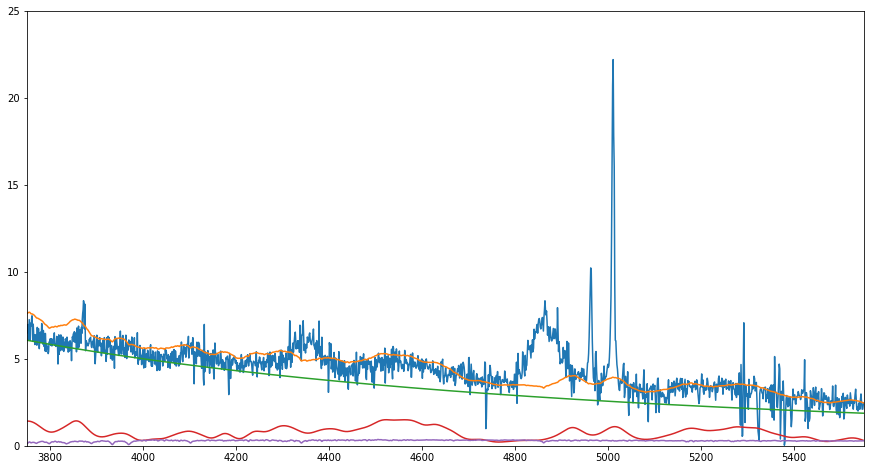

In [4]:
# Let's get a starting point for the continuum fit

continuum_dict={}
continuum_dict['pl_norm']=5
continuum_dict['pl_alpha']=-3
continuum_dict['fe_ii_width']=30
continuum_dict['fe_ii_scale']=1.5
continuum_dict['host_age']=4
continuum_dict['host_scale']=0.2
# here's how to not use continuum parameters
continuum_dict['bal_cont_tau']=None
continuum_dict['bal_cont_scale']=None
continuum_dict['bal_high_width']=None
continuum_dict['bal_high_scale']=None

power_law=spec.power_law(spec.wave,continuum_dict['pl_norm'],continuum_dict['pl_alpha'])
fe_ii=spec.template_fitter(spec.wave,spec.feii_templates,continuum_dict['fe_ii_width'],continuum_dict['fe_ii_scale'])
host=spec.template_fitter(spec.wave,spec.stellar_templates,continuum_dict['host_age'],continuum_dict['host_scale'])
# If you wanted to use Balmer templates
#bal_cont=spec.template_fitter(spec.wave,spec.balmer_cont_templates,continuum_dict['bal_cont_tau'],continuum_dict['bal_cont_scale'])
#bal_high=spec.template_fitter(spec.wave,spec.balmer_highorder_templates,continuum_dict['bal_high_width'],continuum_dict['bal_high_scale'])
cont_model=power_law+fe_ii+host

plt.axis([minWL,maxWL,0,25])
plt.plot(spec.wave,spec.flux)
plt.plot(spec.wave,cont_model)
plt.plot(spec.wave,power_law)
plt.plot(spec.wave,fe_ii)
plt.plot(spec.wave,host)

In [65]:
# set up the relevant emission lines
Hbeta = 4862.721
OIIIa = 4960.295
OIIIb = 5008.239
Hgamma = 4341.68
Hdelta = 4102.0
Hepsilon = 3971.
SII    = 4072.
NeIIIa = 3869.
NeIIIb = 3967.
OIIa   = 3726.
OIIb   = 3729.
NeVa   = 3346.
NeVb   = 3425.
HeII=4685.

OIIIa_off    = OIIIa/OIIIb
Hbeta_off    = Hbeta/OIIIb
SII_off      = SII/OIIIb
NeIIIa_off   = NeIIIa/OIIIb
NeIIIb_off   = NeIIIb/OIIIb
OIIa_off     = OIIa/OIIIb
OIIb_off     = OIIb/OIIIb
NeVa_off     = NeVa/OIIIb
NeVb_off     = NeVb/OIIIb
Hepsilon_off = Hepsilon/Hgamma

# Now we can specify the custom emission template
 The first thing this takes is called tied, it specifies how model parameters are tied together. Tied is a list of strings, with a length that must be divisible by 3. Each entry refers to an amplitude, wavelength, or width of a gaussian emission line, in that order. if you would like a certain model parameter to be free, it's entry in tied will be an empty string. If you want to tie an entry to something else, you can use the following format.

    tied=['','','','p[0]/3','p[1]+5','p[2]']
 
In this example, we would have 2 emission lines. The first emission line has amplitude, wavelength and width that can freely vary. The second emission line has an amplitude tied to be 1/3 of the amplitude of the first line, wavelength tied to be 5 greater than the wavelength of the first line, and width tied to be equal to the width of the first line.

Importantly, the indexing of the ties in the tied list refers to the __index of free parameters__, not the index within the tied array. For example, if we wanted to reverse the order of tied, we would have

    tied=['p[0]/3','p[1]+5','p[2]','','','']
    
Next is free_values, a list of floats that gives the value of each free parameter referenced in tied. For example

    tied=['','','','p[0]/3','p[1]+5','p[2]']
    free_values=[2,4861,10]

### I'm going to create a custom emission template with the following narrow emission lines
- [OIII] 5007
- OII 3729
- OII 3735
- NeIII 3868
- NeIII 3966
- SII 4073
- narrow H Beta
- OIII 4960


Each narrow emission line will be fit with 2 gaussians. Further each narrow line will be tied to have the same profile as all of the other narrow lines. Each line (with the exception of OIII 4960) will have a free amplitude parameter, and the ratio of the amplitudes of the 2 gaussians will be tied to be the same for the whole group. The systemic velocity offset of each gaussian is tied to be the same for the whole group. Note that this means that the line ratios are what is actually tied, bc $\delta \lambda / \lambda = v/c$, so if you want $v_1=v_2$, you need $\delta \lambda_1 / \lambda_1=\delta \lambda_2 / \lambda_2$. Finally the width of each gaussian is tied to be the same for the whole group. Finally the amplitude of OIII 4960 is fixed to be 1/3 that of [OIII] 5007. Let's walk through what tied would look like for this scheme

    tied = ['','','',                                            # we'll make [OIII] 5007 the 'free' line for the group
            '','','',                                            # this will dictate the ties of other narrow lines
                        
            '','p[1]*{0}'.format(OIIa_off),'p[2]',               # the first amplitude of OII 3735 is free, but all other params are tied
            'p[6]*p[3]/p[0]','p[4]*{0}'.format(OIIa_off),'p[5]', # wl ties are dictated by the line ratio relative to [OIII] 5007
                                                                 # for the amp ties, p[0]/p[3]=p[6]/X -> X=p[6]*p[3]/p[0]
            '','p[1]*{0}'.format(OIIb_off),'p[2]',
            'p[7]*p[3]/p[0]','p[4]*{0}'.format(OIIb_off),'p[5]',
            
            '','p[1]*{0}'.format(NeIIIa_off),'p[2]',
            'p[8]*p[3]/p[0]','p[4]*{0}'.format(NeIIIa_off),'p[5]',
            
            '','p[1]*{0}'.format(NeIIIb_off),'p[2]',
            'p[9]*p[3]/p[0]','p[4]*{0}'.format(NeIIIb_off),'p[5]',
            
            '','p[1]*{0}'.format(SII_off),'p[2]',
            'p[10]*p[3]/p[0]','p[4]*{0}'.format(SII_off),'p[5]',
            
            '','p[1]*{0}'.format(Hbeta_off),'p[2]',
            'p[11]*p[3]/p[0]','p[4]*{0}'.format(Hbeta_off),'p[5]',
            
            'p[0]*0.33','p[1]*{0}'.format(OIIIa_off),'p[2]',      # OIII 4960 is tied to have 1/3 the amplitude of [OIII] 5007
            'p[3]*0.33','p[4]*{0}'.format(OIIIa_off),'p[5]']

## I will also add broad emission lines as follows


    - H Beta -> 4 gaussians 
    - H Delta -> 1 gaussian
    - H Gamma -> 1 gaussian
    - H Epsilon -> 1 gaussian
    - He II -> 1 gaussian
    
All lines will be allowed to vary freely, except the profile of H epsilon will be tied to that of H Gamma

In [66]:
tied=['','','',
      '','','',
      '','p[1]*{0}'.format(OIIa_off),'p[2]',
      'p[6]*p[3]/p[0]','p[4]*{0}'.format(OIIa_off),'p[5]',
      '','p[1]*{0}'.format(OIIb_off),'p[2]',
      'p[7]*p[3]/p[0]','p[4]*{0}'.format(OIIb_off),'p[5]',
      '','p[1]*{0}'.format(NeIIIa_off),'p[2]',
      'p[8]*p[3]/p[0]','p[4]*{0}'.format(NeIIIa_off),'p[5]',
      '','p[1]*{0}'.format(NeIIIb_off),'p[2]',
      'p[9]*p[3]/p[0]','p[4]*{0}'.format(NeIIIb_off),'p[5]',
      '','p[1]*{0}'.format(SII_off),'p[2]',
      'p[10]*p[3]/p[0]','p[4]*{0}'.format(SII_off),'p[5]',
      '','p[1]*{0}'.format(Hbeta_off),'p[2]',
      'p[11]*p[3]/p[0]','p[4]*{0}'.format(Hbeta_off),'p[5]',
      'p[0]*0.33','p[1]*{0}'.format(OIIIa_off),'p[2]',
      'p[3]*0.33','p[4]*{0}'.format(OIIIa_off),'p[5]',
      '','','','','','','','','','','','',
      '','','',
      '','','',
      '','p[28]*{0}'.format(Hepsilon_off),'p[29]',
      '','','']

# IMPORTANT NOTE: CURRENTLY THE STRING FORMAT FOR TIED IS NOT VERY FLEXIBLE
# TIES MUST HAVE THE FORM 'p[idx]+float' 'p[idx]-float' 'p[idx]*float' 'p[idx]/float'
# OR 'p[idx1]*p[idx2]/p[idx3]' BUT IT MUST HAVE THAT ORDER, IE YOU CAN'T DO 'p[idx1]/p[idx2]*p[idx3]'

start_amp=4
start_width=5
start_broad_width=15
max_broad_offset=20 #angstroms
max_narrow_offset=10 #angstroms
min_amp=0.1
max_amp=100
min_width=1        #angstroms
min_broad_width=5  #angstroms
broad_max=50       # max width for broad lines
narrow_max=10      # max width for narrow lines

# free values gives the parameter values for each free parameter in tied
free_values=[start_amp,OIIIb,start_width,
             start_amp,OIIIb,start_width,
             start_amp,start_amp,start_amp,start_amp,start_amp,start_amp,
             start_amp,Hbeta-5,start_broad_width,
             start_amp,Hbeta,start_broad_width,
             start_amp,Hbeta,start_broad_width,
             start_amp,Hbeta+5,start_broad_width,
             start_amp,Hdelta,start_broad_width,
             start_amp,Hgamma,start_broad_width,
             start_amp,
             start_amp,HeII,start_broad_width]

# lower_bounds gives the lower bounds for each free parameter
lower_bounds=[min_amp,OIIIb-max_narrow_offset,min_width,
              min_amp,OIIIb-max_narrow_offset,min_width,
              min_amp,min_amp,min_amp,min_amp,min_amp,min_amp,
              min_amp,Hbeta-max_broad_offset,min_broad_width,
              min_amp,Hbeta-max_broad_offset,min_broad_width,
              min_amp,Hbeta-max_broad_offset,min_broad_width,
              min_amp,Hbeta-max_broad_offset,min_broad_width,
              min_amp,Hdelta-max_broad_offset,min_broad_width,
              min_amp,Hgamma-max_broad_offset,min_broad_width,
              min_amp,
              min_amp,HeII-max_broad_offset,min_broad_width]

# upper_bounds gives the upper bounds for each free parameter
upper_bounds=[max_amp,OIIIb+max_narrow_offset,narrow_max,
              max_amp,OIIIb+max_narrow_offset,narrow_max,
              max_amp,max_amp,max_amp,max_amp,max_amp,max_amp,
              max_amp,Hbeta+max_broad_offset,broad_max,
              max_amp,Hbeta+max_broad_offset,broad_max,
              max_amp,Hbeta+max_broad_offset,broad_max,
              max_amp,Hbeta+max_broad_offset,broad_max,
              max_amp,Hdelta+max_broad_offset,broad_max,
              max_amp,Hgamma+max_broad_offset,broad_max,
              max_amp,
              max_amp,HeII+max_broad_offset,broad_max]

In [67]:
len(tied)/3

24.0

In [68]:
minWL=None # fit all of spec.wave
maxWL=None

nwalkers=200
nsteps=10000

spec.fit_custom_emission_emcee(nwalkers,nsteps,minWL,maxWL,continuum_dict,free_values,tied,lower_bounds,upper_bounds)

100%|██████████| 10000/10000 [16:18<00:00, 10.22it/s]


In [69]:
print(spec.params_keys)
# Notice the naming convention is numbered by the number of the corresponding gaussian
# There are jumps in number because some gaussians don't have any associated free parameters

['pl_norm' 'pl_alpha' 'fe_ii_width' 'fe_ii_scale' 'host_age' 'host_scale'
 'amp1' 'wl1' 'width1' 'amp2' 'wl2' 'width2' 'amp3' 'amp5' 'amp7' 'amp9'
 'amp11' 'amp13' 'amp17' 'wl17' 'width17' 'amp18' 'wl18' 'width18' 'amp19'
 'wl19' 'width19' 'amp20' 'wl20' 'width20' 'amp21' 'wl21' 'width21'
 'amp22' 'wl22' 'width22' 'amp23' 'amp24' 'wl24' 'width24']


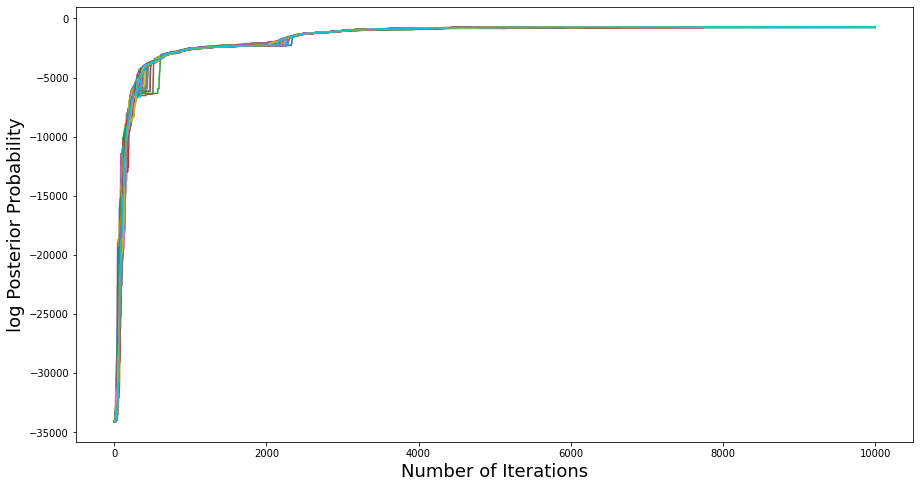

In [70]:
sampler=spec.sampler

log_prob=sampler.get_log_prob()

plt.xlabel('Number of Iterations',fontsize=18)
plt.ylabel('log Posterior Probability',fontsize=18)
plt.plot(log_prob[:,:])
plt.show()

Text(0.5, 0, 'Walker')

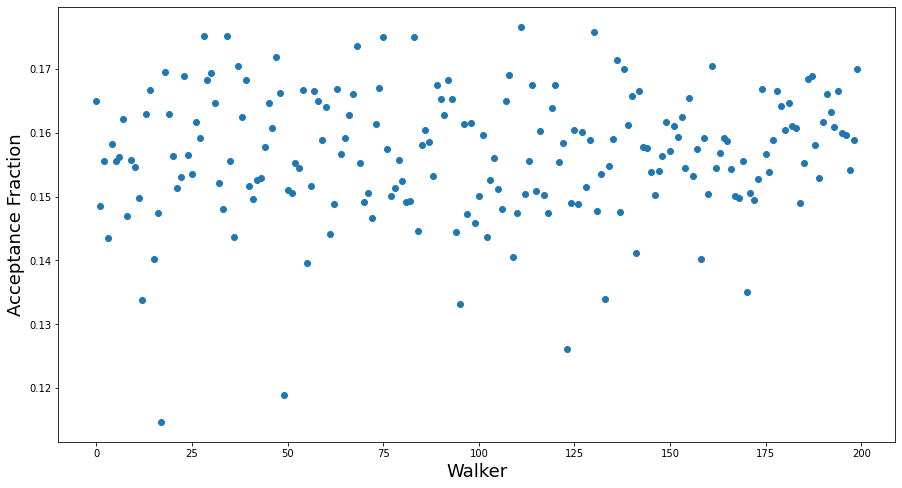

In [71]:
plt.scatter(np.arange(nwalkers),sampler.acceptance_fraction)
plt.ylabel('Acceptance Fraction',fontsize=18)
plt.xlabel('Walker',fontsize=18)

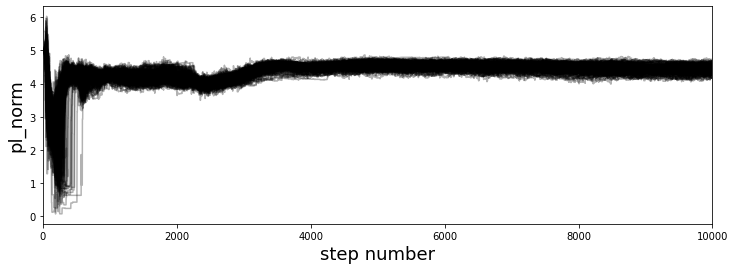

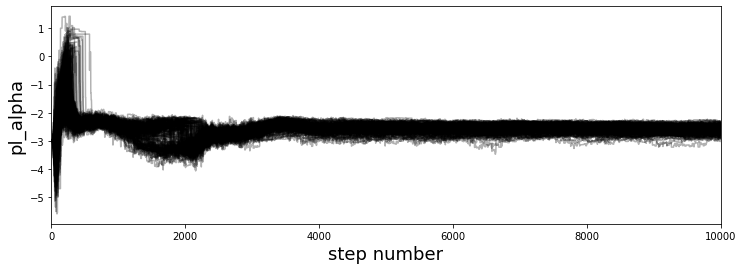

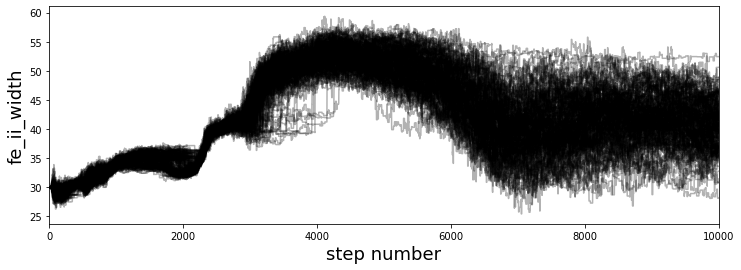

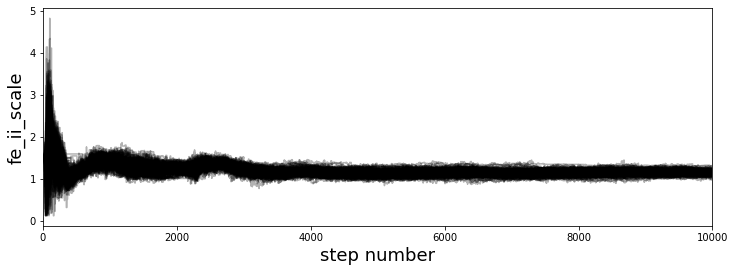

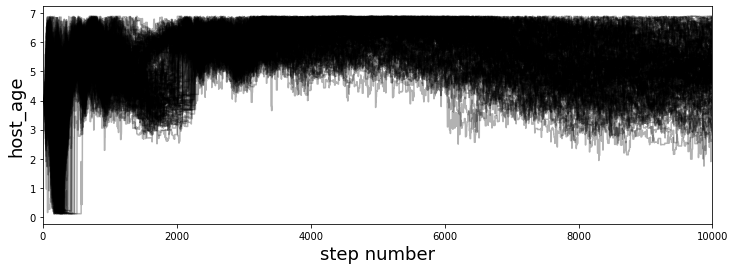

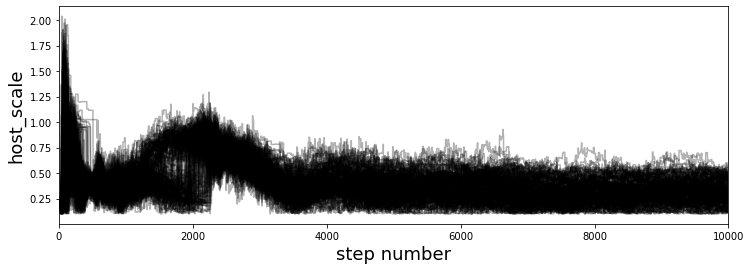

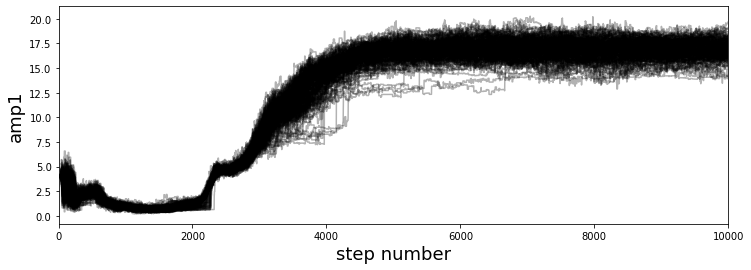

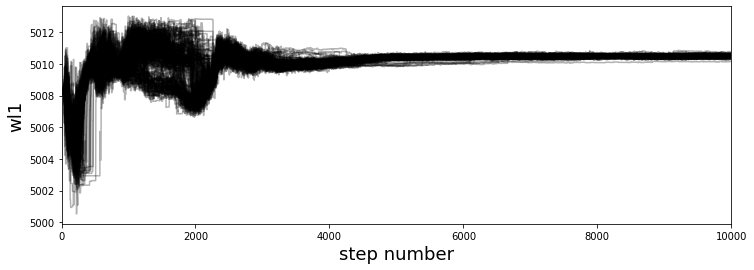

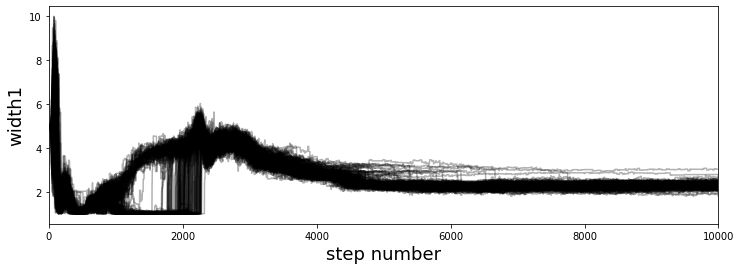

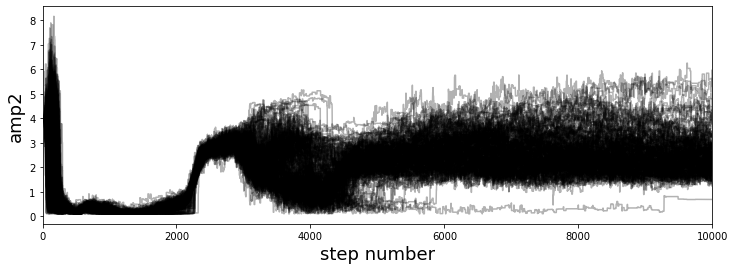

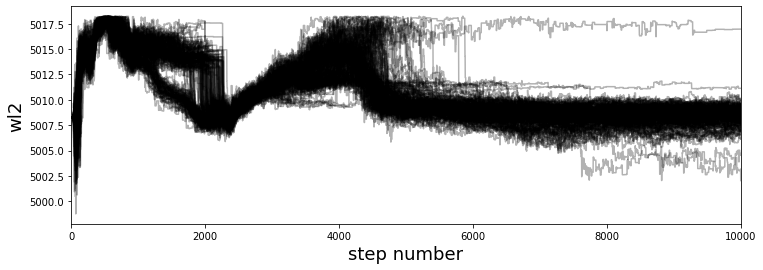

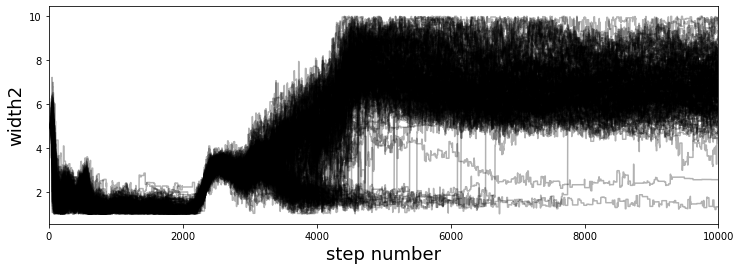

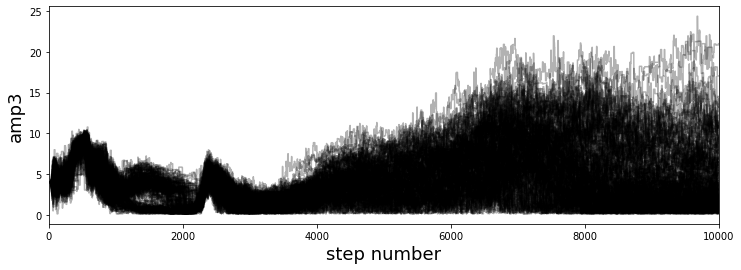

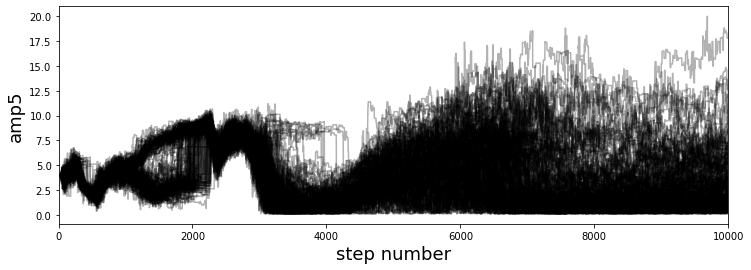

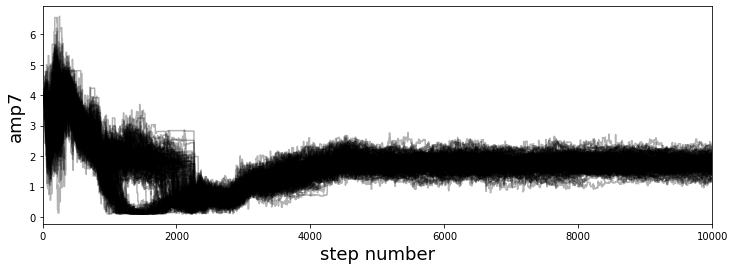

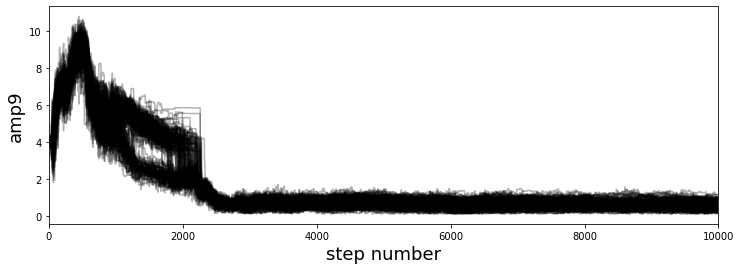

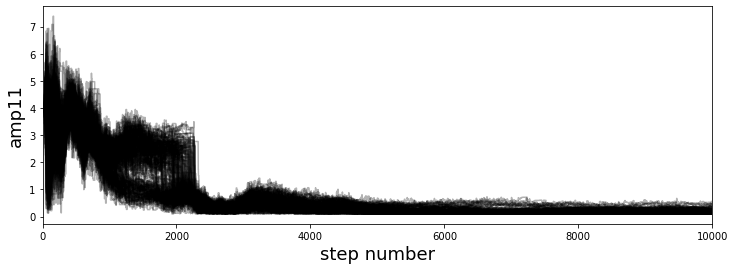

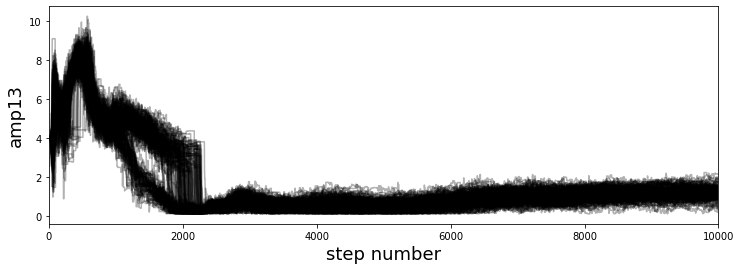

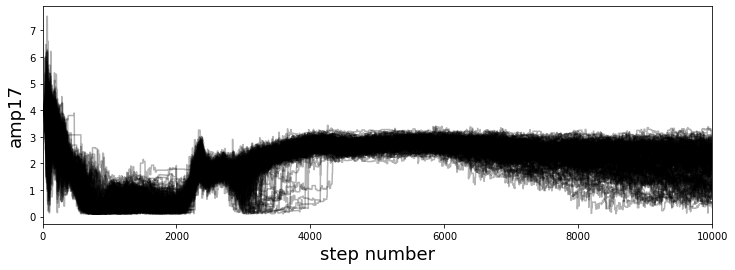

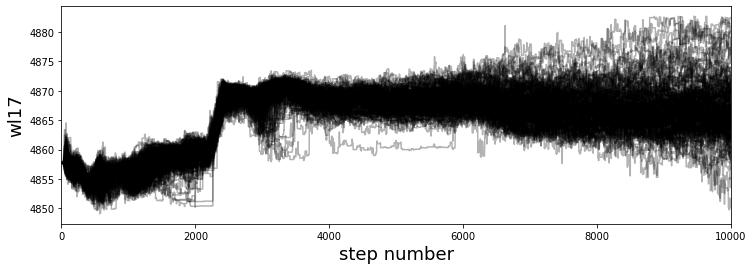

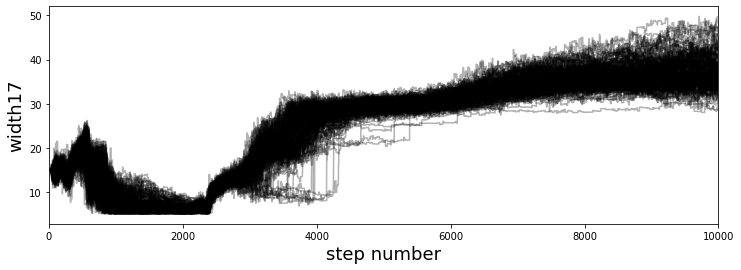

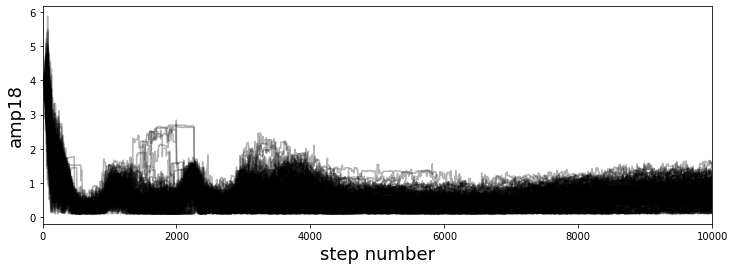

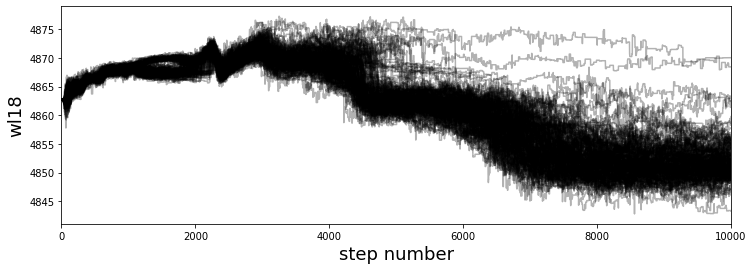

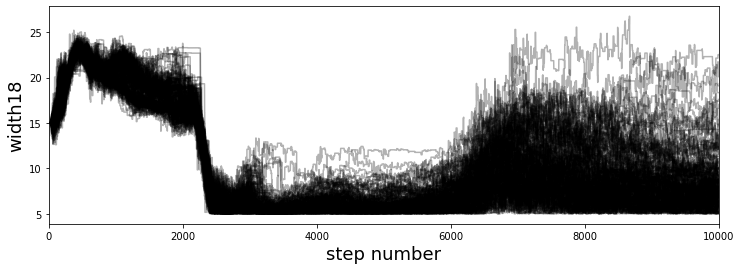

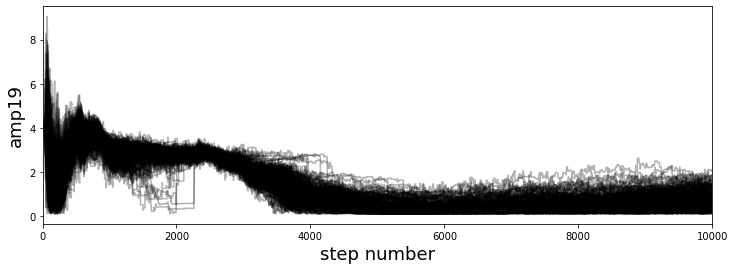

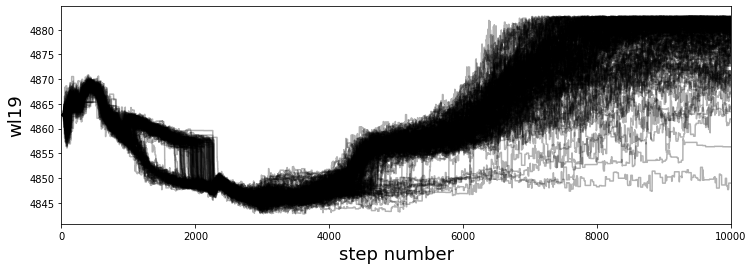

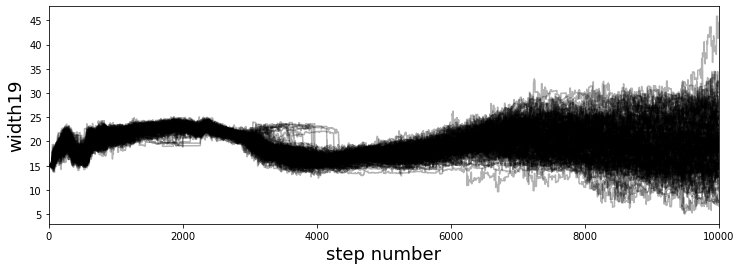

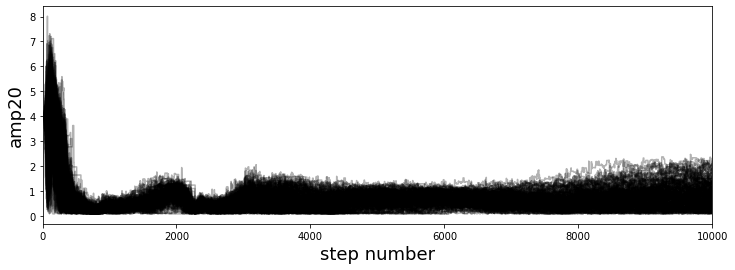

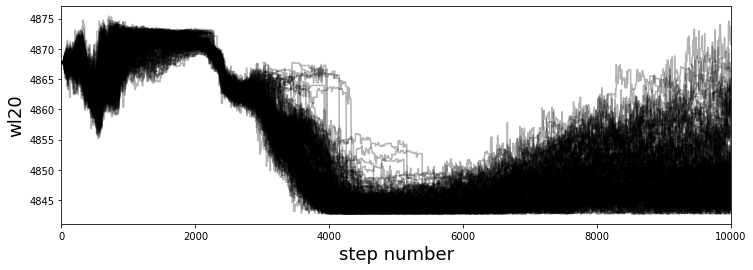

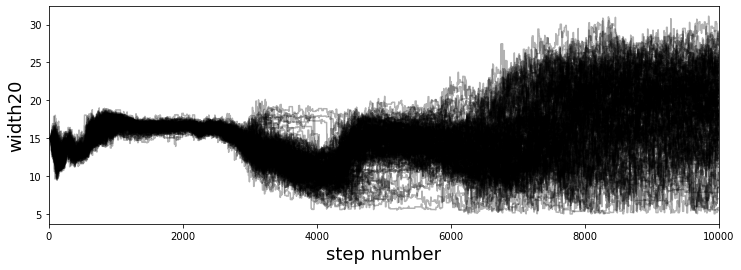

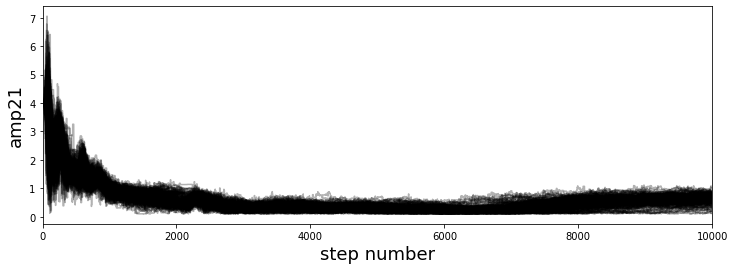

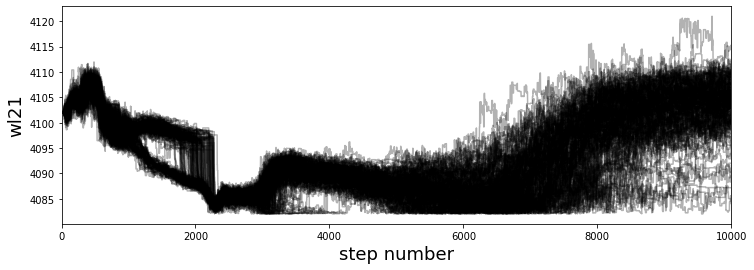

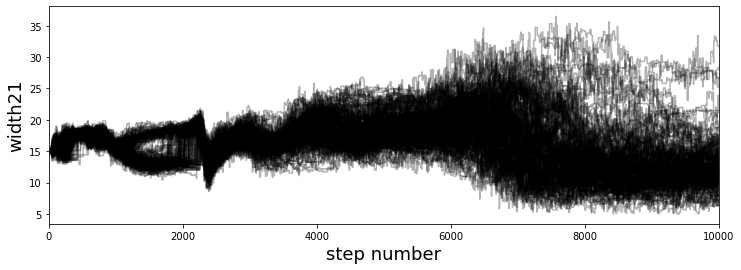

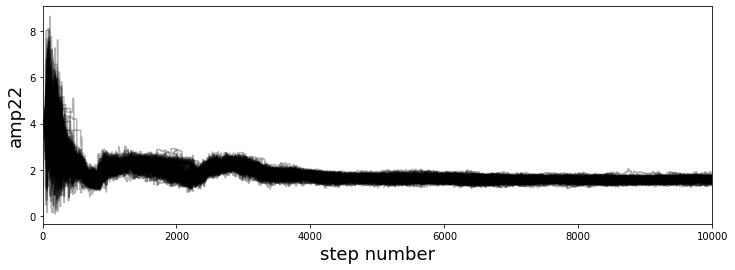

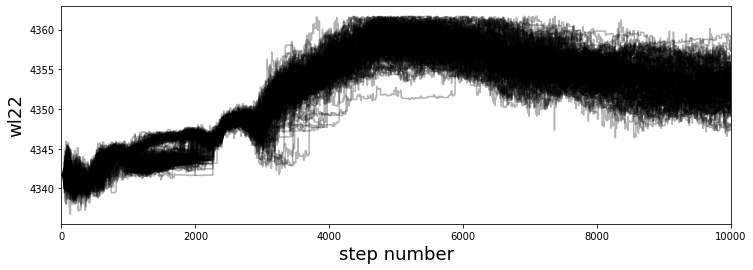

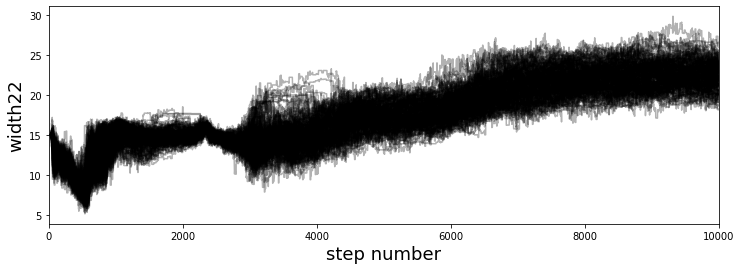

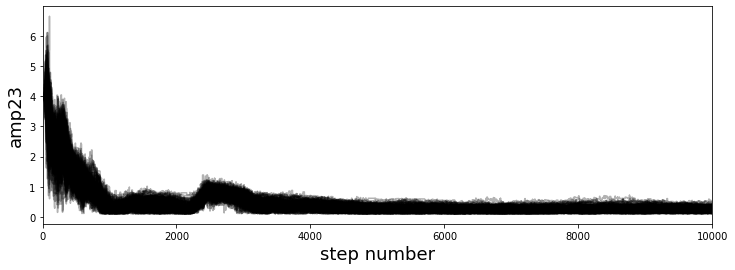

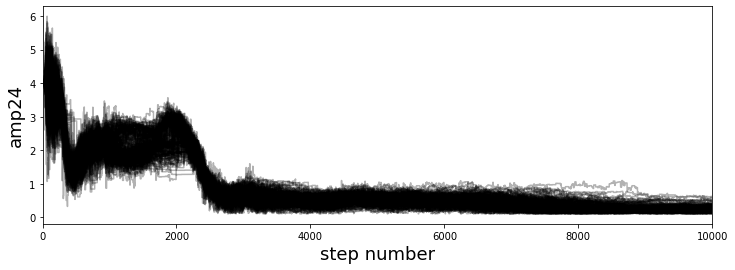

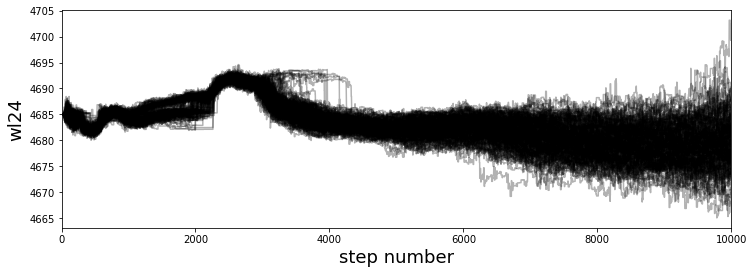

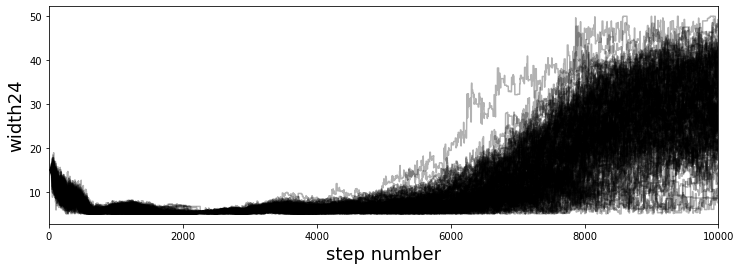

In [72]:
rcParams['figure.figsize'] = 12,4

samples = sampler.get_chain()
ndim=len(spec.params_keys)
for i in range(ndim):

    plt.plot(samples[:, :, i], "k", alpha=0.3)
    plt.xlim(0, len(samples))
    plt.ylabel(spec.params_keys[i],fontsize=18)
    plt.xlabel("step number",fontsize=18)
    plt.show()

In [77]:
# Now we decide a burnin and a thin value, then flatten the samples

#tau = sampler.get_autocorr_time()
#print('mean autocorrelation time '+str(np.average(tau)))


burnin=5000
thin=100

flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)

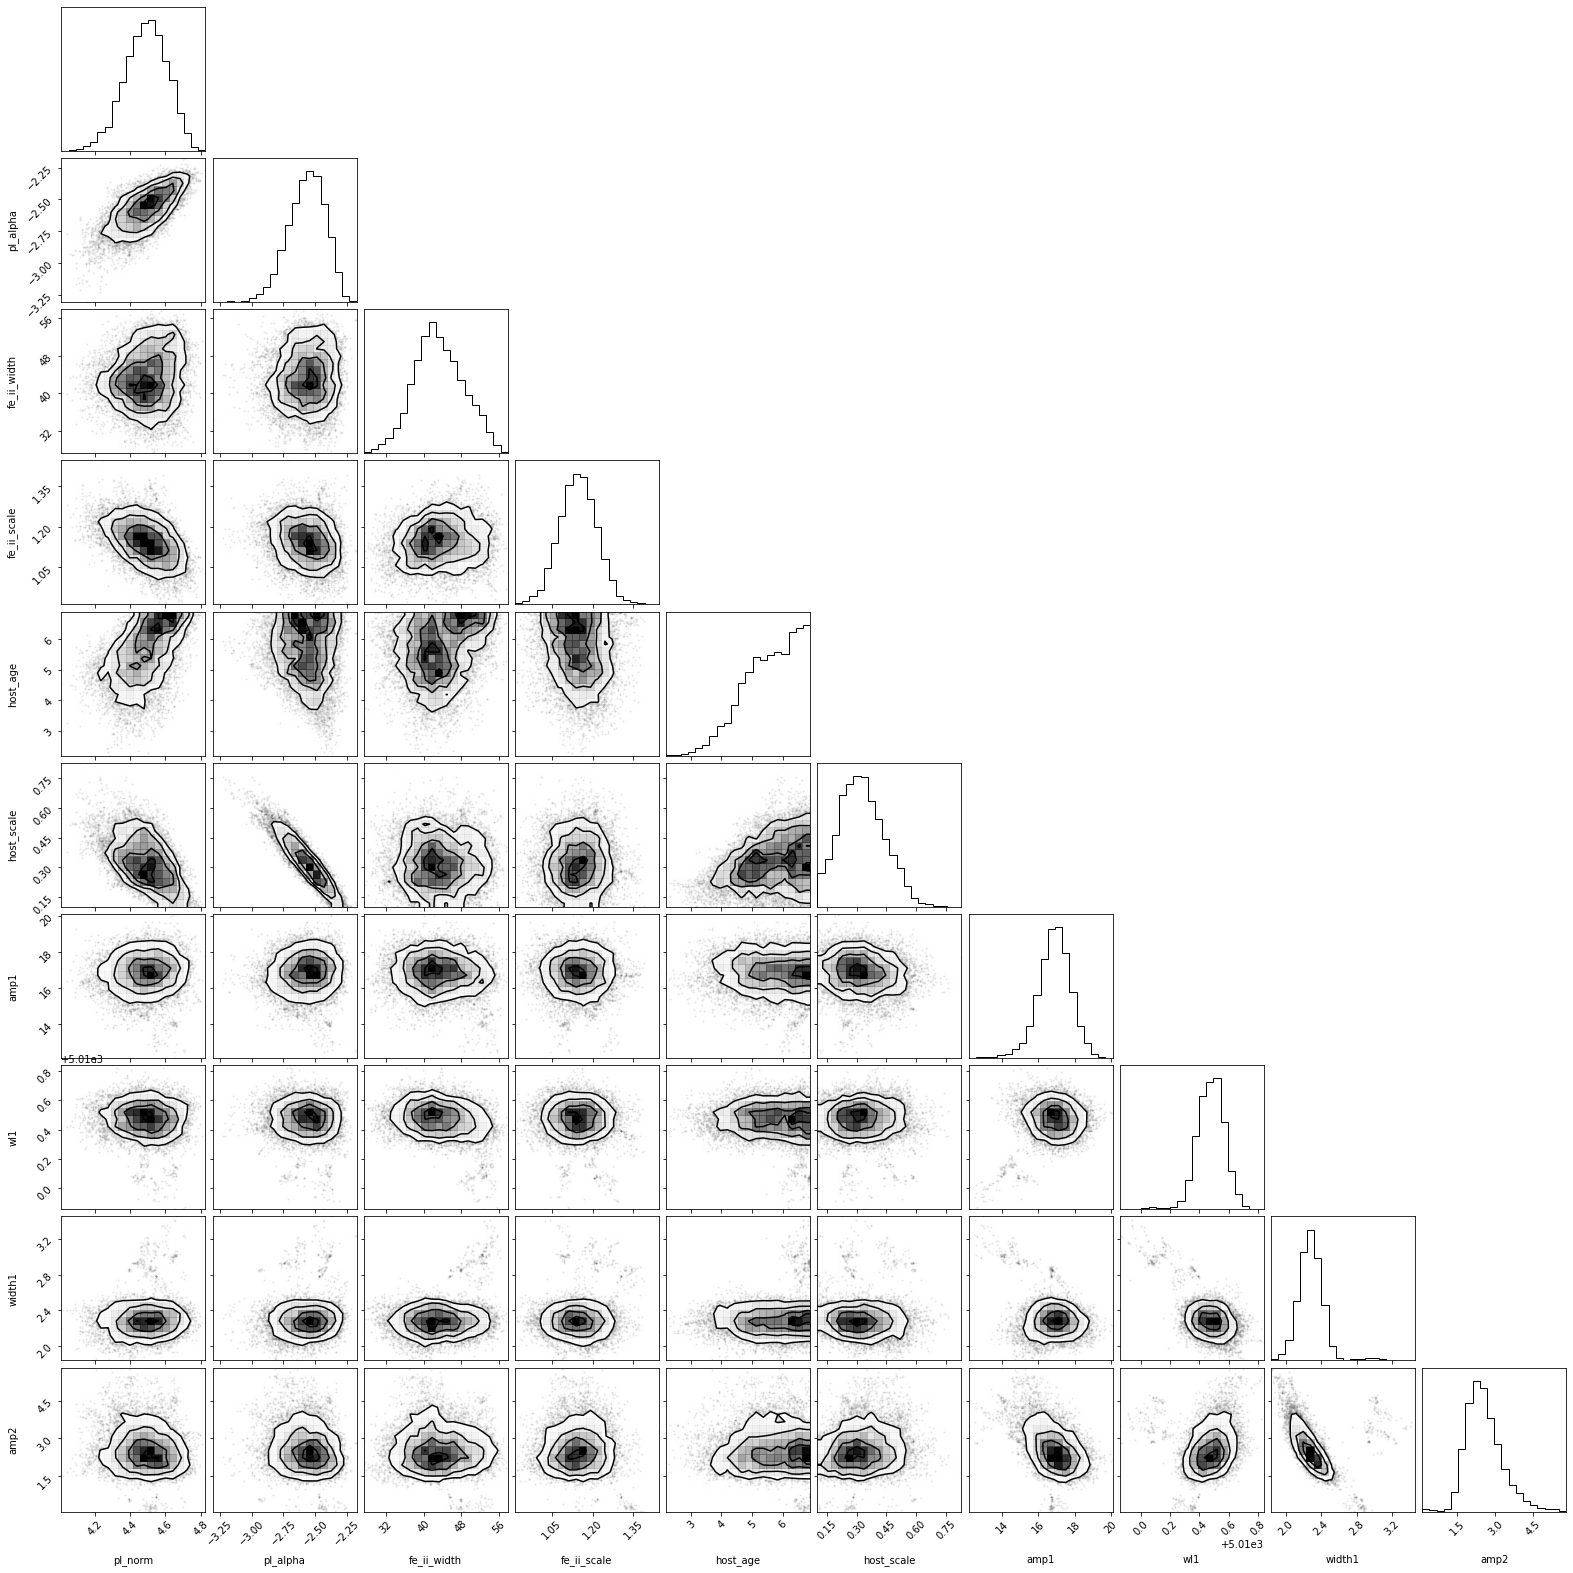

In [78]:
# we can make corner plots


fig = corner.corner(flat_samples[:,:10], labels=spec.params_keys[:10])

(3750.0, 5550.0, 0.0, 15.0)

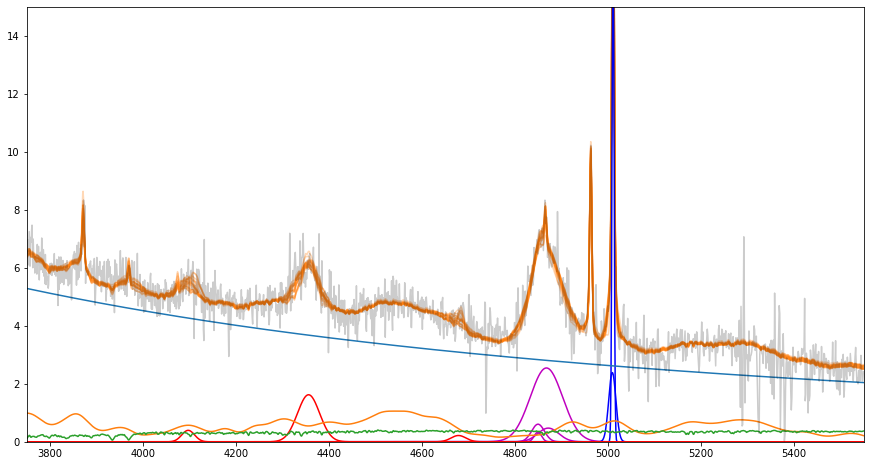

In [79]:
# Now we take some random samples of the converged chain and plot the model 

rcParams['figure.figsize'] = 15,8

num_samples=20

inds = np.random.randint(len(flat_samples), size=num_samples)
for ind in inds:
    params = flat_samples[ind]
    plt.plot(spec.wave, spec.construct_custom_model_emcee(params), "C1", alpha=0.3)
    
# pick a random sample to plot individual model components
inds = np.random.randint(len(flat_samples), size=1)
params=params = flat_samples[ind]
hbeta=params[18:30]
hdelta=params[30:33]
hgamma=params[33:36]
heii=params[37:40]
oiiib=params[6:12]
plt.plot(spec.wave, spec.gaussian(spec.wave,hbeta[0],hbeta[1],hbeta[2]),c='m')
plt.plot(spec.wave, spec.gaussian(spec.wave,hbeta[3],hbeta[4],hbeta[5]),c='m')
plt.plot(spec.wave, spec.gaussian(spec.wave,hbeta[6],hbeta[7],hbeta[8]),c='m')
plt.plot(spec.wave, spec.gaussian(spec.wave,hbeta[9],hbeta[10],hbeta[11]),c='m')
plt.plot(spec.wave, spec.gaussian(spec.wave,oiiib[0],oiiib[1],oiiib[2]),c='b')
plt.plot(spec.wave, spec.gaussian(spec.wave,oiiib[3],oiiib[4],oiiib[5]),c='b')
plt.plot(spec.wave, spec.gaussian(spec.wave,hdelta[0],hdelta[1],hdelta[2]),c='r')
plt.plot(spec.wave, spec.gaussian(spec.wave,hgamma[0],hgamma[1],hgamma[2]),c='r')
plt.plot(spec.wave, spec.gaussian(spec.wave,heii[0],heii[1],heii[2]),c='r')

plt.plot(spec.wave, spec.power_law(spec.wave,params[0],params[1]))
plt.plot(spec.wave, spec.template_fitter(spec.wave,spec.feii_templates,params[2],params[3]))
plt.plot(spec.wave, spec.template_fitter(spec.wave,spec.stellar_templates,params[4],params[5]))
    
plt.plot(spec.wave, spec.flux, c='k',alpha=0.2)
plt.axis([3750,5550,0,15])